## Cell subsampling using TopACeDo

In [1]:
%load_ext autotime
%config InlineBackend.figure_format = 'retina'

import scarf
scarf.__version__

'0.11.0'

time: 1.55 s (started: 2021-07-31 12:00:27 +02:00)


---
### 1) Installing dependencies

We need to install the TopACeDo algorithm to perform subsampling:

In [2]:
!pip install git+https://github.com/fraenkel-lab/pcst_fast.git@deb3236cc26ee9fee77d5af40fac3f12bb753850
!pip install -U topacedo

  Cloning https://github.com/fraenkel-lab/pcst_fast.git (to revision deb3236cc26ee9fee77d5af40fac3f12bb753850) to c:\users\parashar\appdata\local\temp\pip-req-build-oc5rq4_f


  Running command git clone -q https://github.com/fraenkel-lab/pcst_fast.git 'C:\Users\parashar\AppData\Local\Temp\pip-req-build-oc5rq4_f'
  Running command git rev-parse -q --verify 'sha^deb3236cc26ee9fee77d5af40fac3f12bb753850'
  Running command git fetch -q https://github.com/fraenkel-lab/pcst_fast.git deb3236cc26ee9fee77d5af40fac3f12bb753850
  Running command git checkout -q deb3236cc26ee9fee77d5af40fac3f12bb753850


time: 8.64 s (started: 2021-07-31 12:00:29 +02:00)


---
### 2) Fetching pre-processed data

In [3]:
# Loading preanalyzed dataset that was processed in the `basic_tutorial` vignette
scarf.fetch_dataset('tenx_5K_pbmc_rnaseq', as_zarr=True, save_path='scarf_datasets')

INFO: Download finished! File saved here: C:\Users\parashar\Desktop\scarf_vignettes\scarf_datasets\tenx_5K_pbmc_rnaseq\data.zarr.tar.gz
INFO: Extracting Zarr file for tenx_5K_pbmc_rnaseq
time: 8.77 s (started: 2021-07-31 12:00:38 +02:00)


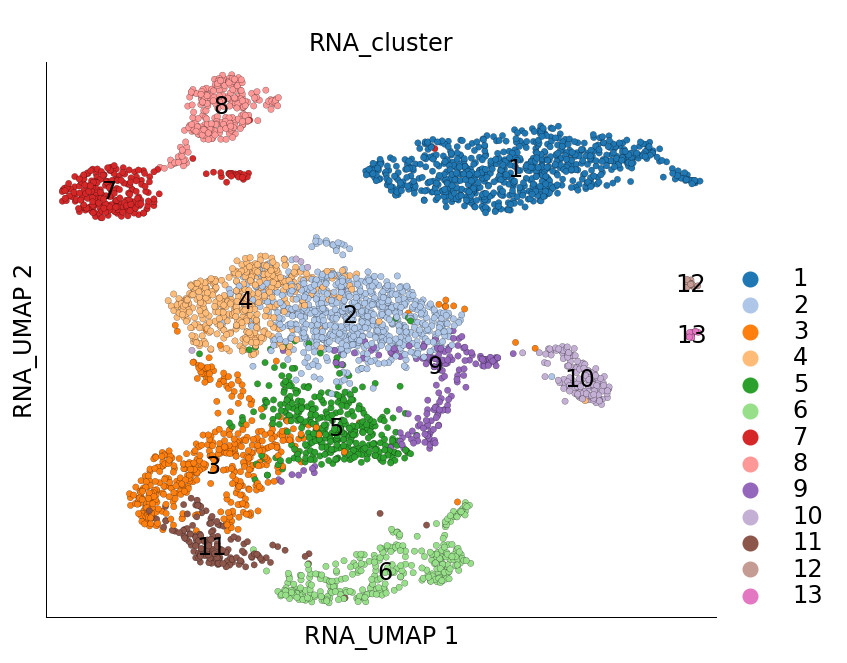

time: 1.06 s (started: 2021-07-31 12:00:46 +02:00)


In [4]:
ds = scarf.DataStore('scarf_datasets/tenx_5K_pbmc_rnaseq/data.zarr')
ds.plot_layout(layout_key='RNA_UMAP', color_by='RNA_cluster')

---
### 3) Run TopACeDo downsampler

UMAP, clustering and marker identification together allow a good understanding of cellular diversity. However, one can still choose from a plethora of other analysis on the data. For example, identification of cell differentiation trajectories. One of the major challenges to run these analysis could be the size of the data. Scarf performs a topology conserving downsampling of the data based on the cell neighbourhood graph. This downsampling aims to maximize the heterogeneity while sampling cells from the data.

Here we run the TopACeDo downsampling algorithm that leverages Scarf's KNN graph to perform a manifold preserving subsampling of cells. The subsampler can be invoked directly from Scarf's DataStore object.

In [5]:
ds.run_topacedo_sampler(cluster_key='RNA_cluster', max_sampling_rate=0.1)

Constructing graph from dendrogram: 100%|██████████████████████████████████████████| 3939/3939 [00:00<00:00, 80782.74it/s]

INFO: 384 cells (9.75%) sub-sampled. Subsample to Seed (165 cells) ratio: 2.327


time: 1.31 s (started: 2021-07-31 12:00:48 +02:00)


As a result of subsampling the subsampled cells are marked True under the cell metadata column `RNA_sketched`. We can visualize these cells using `plot_layout`

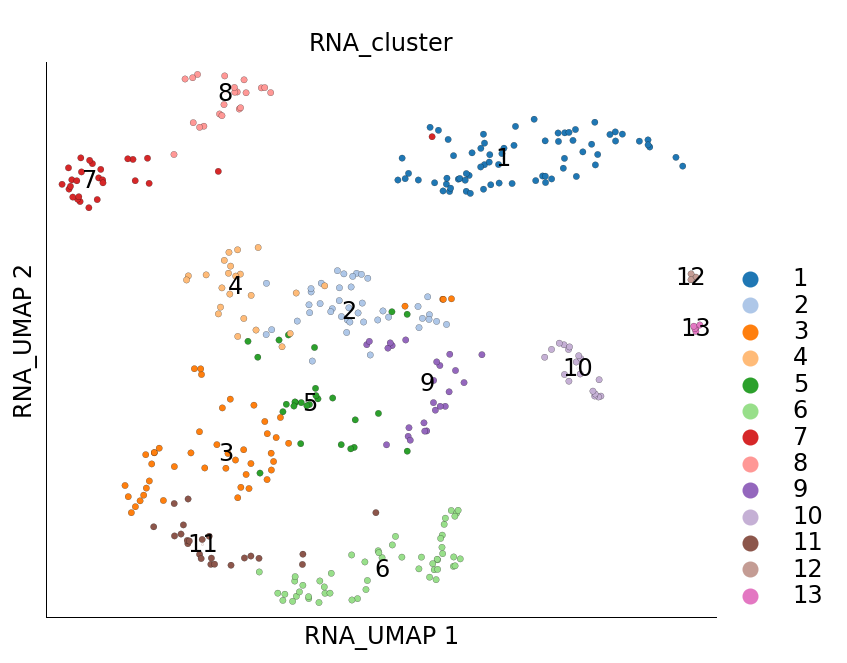

time: 422 ms (started: 2021-07-31 12:00:49 +02:00)


In [6]:
ds.plot_layout(layout_key='RNA_UMAP', color_by='RNA_cluster', subselection_key='RNA_sketched')

It may also be interesting to visualize the cells that were marked as `seed cells` used when PCST was run. These cells are marked under the column `RNA_sketch_seeds`.

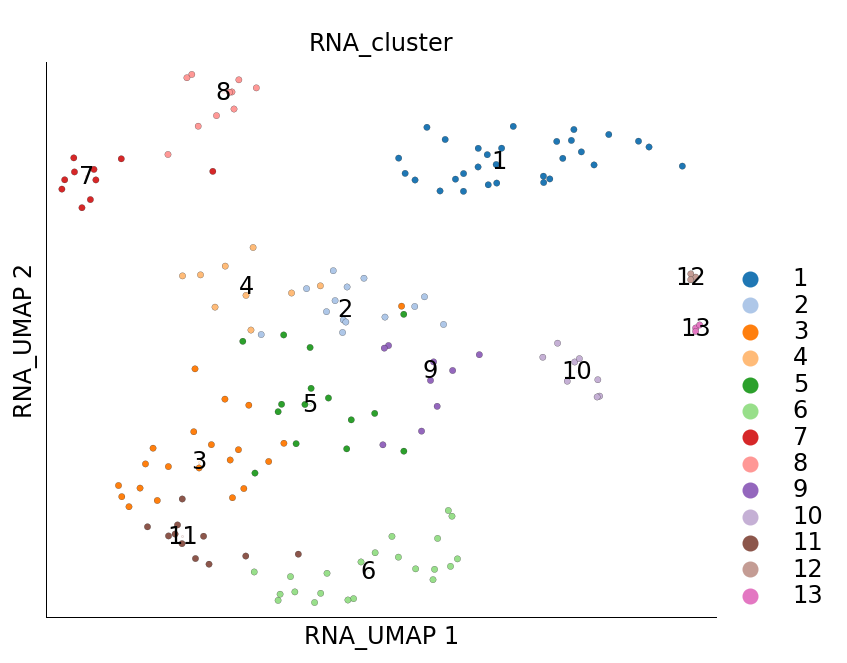

time: 328 ms (started: 2021-07-31 12:00:49 +02:00)


In [7]:
ds.plot_layout(layout_key='RNA_UMAP', color_by='RNA_cluster', subselection_key='RNA_sketch_seeds')

---
### 4) Intermediate parameters of downsampling

To identify the seed cells, the subsampling algorithm calculates cell densities based on neighbourhood degrees. Regions of higher cell density get a sampling penalty. The neighbourhood degree of individual cells are stored under the column `RNA_cell_density`.

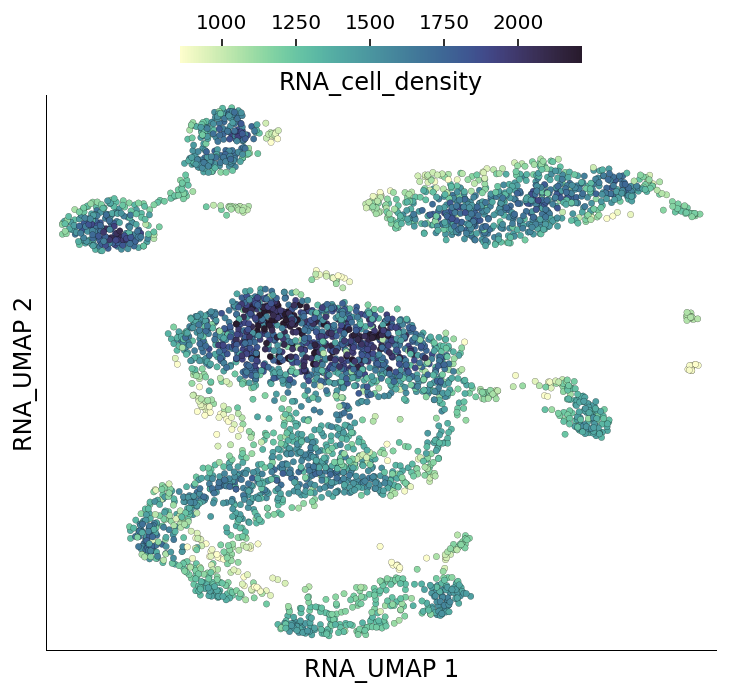

time: 454 ms (started: 2021-07-31 12:00:50 +02:00)


In [8]:
ds.plot_layout(layout_key='RNA_UMAP', color_by='RNA_cell_density')

The dowsampling algorithm also identifies regions of the graph where cells form tightly connected groups by calculating mean shared nearest neighbours of each cell's nieghbours. The tightly connected regions get a sampling award. These values can be accessed from under the cell metadata column `RNA_snn_value`.

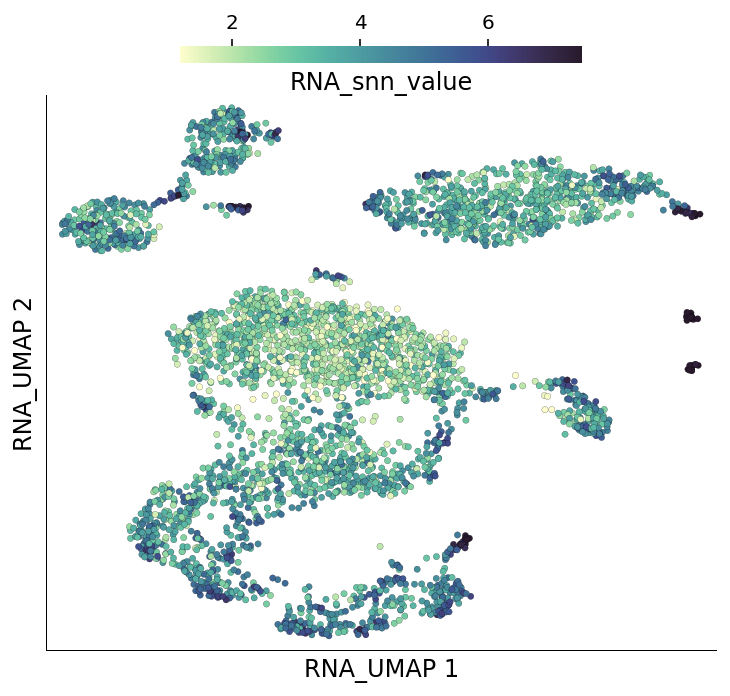

time: 453 ms (started: 2021-07-31 12:00:50 +02:00)


In [9]:
ds.plot_layout(layout_key='RNA_UMAP', color_by='RNA_snn_value')

---
That is all for this vignette.